# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from math import ceil
from sklearn.linear_model import LinearRegression


## Step 1: Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='base_billings')

In [3]:
df.sample(10)

Document Currency  Enterprise BU Desc Frequency  \
2752                AUD    Experience Cloud      1TME   
27965               JPY            Creative      ONGO   
19407               EUR  Print & Publishing       NaN   
481                 AUD            Creative       NaN   
30598               JPY    Experience Cloud      ONGO   
8322                CHF      Document Cloud       NaN   
35639               SEK      Document Cloud       NaN   
45707               USD    Experience Cloud      ONGO   
7679                CHF            Creative       NaN   
33993               PHP            Creative       NaN   

      Invoice Fiscal Year Period Desc Product Config Type Rev Rec Category  \
2752                          2015-03               ONORE                D   
27965                         2019-02                 NaN                D   
19407                         2017-06                  1Y              NaN   
481                           2016-02                  1Y                D   
30598                         2019-10                 NaN                D   
8322                          2018-02               MTHLY                D   
35639                         2018-08                 NaN                A   
45707                         2015-12               ONORE              NaN   
7679                          2018-05                 NaN              NaN   
33993                         2020-02                  1Y                D   

      Rule For Bill Date Sales Type  Subscription Term  \
2752                  YQ   DEFERRED                  0   
27965                 YA   DEFERRED                  0   
19407                NaN   DEFERRED                 12   
481                   YC   DEFERRED                  0   
30598                 Y1   DEFERRED                  0   
8322                  Y3   DEFERRED                  1   
35639                NaN   DEFERRED                 12   
45707                NaN   DEFERRED                 12   
7679                 NaN   DEFERRED                  0   
33993                 YA   DEFERRED                 12   

       Completed Sales ( DC )  Completed Sales  
2752                 55687.09         43474.91  
27965               384648.00          3469.52  
19407                    0.00             0.00  
481                 105000.00         74316.90  
30598              3309750.00         31177.84  
8322                  5030.00          5165.13  
35639                -4871.73          -548.74  
45707                    0.00             0.00  
7679                  3467.00          3606.92  
33993              2166591.67         42680.72

### Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise BU Desc', 'Frequency',
       'Invoice Fiscal Year Period Desc', 'Product Config Type',
       'Rev Rec Category', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales ( DC )', 'Completed Sales'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise BU Desc': 'BU',
                                 'Invoice Fiscal Year Period Desc': 'period',
                                 'Product Config Type': 'config',
                                 'Rev Rec Category': 'rev_req_type',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales ( DC )': 'DC_amount',
                                 'Completed Sales': 'US_amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config', 'rev_req_type',
       'rebill_rule', 'Sales Type', 'Subscription Term', 'DC_amount',
       'US_amount'],
      dtype='object')

### Filter that removes any currency that has  < 10 transactions. 


In [7]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
print(vc)

USD    12427
EUR     7725
GBP     5714
AUD     5068
JPY     4919
CHF     2389
SEK     2260
DKK     2172
NOK     1854
CAD     1520
HKD      486
BRL      466
RUB      461
KRW      247
CLP      211
COP      210
ARS      210
SGD      209
PEN      190
INR      181
PHP      151
TWD      148
THB      144
MYR      138
IDR      132
NZD       67
ILS       38
TRY       27
SAR        4
BMD        2
AED        1
MXP        1
Name: curr, dtype: int64


In [8]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

### Just keeping track of the currencies we removed in our model_dict data structure

In [9]:
remove_these = vc[vc.values <= 10].index
model_dict = {'curr_removed': list(vc[remove_these].index)}
delete_curr = list(remove_these)

## The FX database does not have information on the following currencies
 - AED (United Arab Emirates Dirham)
 - BMD (Bermudan Dollar)
 - MXP (Mexican Peso)
 - TRY (Turkish Lira)

In [10]:
if 'TRY' not in model_dict:
    model_dict['curr_removed'].append('TRY')
    delete_curr.append('TRY')
    a = a.drop('TRY')
    
print('Model dictionary', model_dict)
print('Deleted Currencies', delete_curr)

Model dictionary {'curr_removed': ['SAR', 'BMD', 'AED', 'MXP', 'TRY']}
Deleted Currencies ['SAR', 'BMD', 'AED', 'MXP', 'TRY']


In [11]:
print("---Removing infrequent currencies from billings history---")
print('Total number of currencies in the base billings file: ', len(vc))
if len(model_dict['curr_removed'])==0:
    print('No currencies were removed, all contained 10 or more billings')
    print('Currencies in the base billings file')
    for item in a:
        print(a[item], end = " ")
else:
    print('\n Currencies were removed: ', len(model_dict['curr_removed']))

    for item in remove_these:
        print(item, ', ', end="")
        
    print("\n\n{} Remaining currencies: ".format(len(a)))
    for item in a:
        print(item, ', ', end="")

---Removing infrequent currencies from billings history---
Total number of currencies in the base billings file:  32

 Currencies were removed:  5
SAR , BMD , AED , MXP , 

27 Remaining currencies: 
USD , EUR , GBP , AUD , JPY , CHF , SEK , DKK , NOK , CAD , HKD , BRL , RUB , KRW , CLP , COP , ARS , SGD , PEN , INR , PHP , TWD , THB , MYR , IDR , NZD , ILS , 

### Removing any of the values that are zero

In [12]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['DC_amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  49764
This is the length of the dataframe after removing zeros:  46285


In [13]:
df.head(30)

curr        BU Frequency   period config rev_req_type rebill_rule  \
1   ARS  Creative       NaN  2019-03     1Y            D         NaN   
2   ARS  Creative       NaN  2019-03     1Y            D          Y3   
3   ARS  Creative       NaN  2019-03     1Y            D          YA   
4   ARS  Creative       NaN  2019-03  MTHLY            D         NaN   
5   ARS  Creative       NaN  2019-03  MTHLY            D          Y3   
6   ARS  Creative       NaN  2019-04     1Y            D         NaN   
7   ARS  Creative       NaN  2019-04     1Y            D          Y3   
8   ARS  Creative       NaN  2019-04     1Y            D          YA   
9   ARS  Creative       NaN  2019-04  MTHLY            D         NaN   
10  ARS  Creative       NaN  2019-04  MTHLY            D          Y3   
11  ARS  Creative       NaN  2019-05     1Y            D         NaN   
12  ARS  Creative       NaN  2019-05     1Y            D         NaN   
13  ARS  Creative       NaN  2019-05     1Y            D          Y3   
14  ARS  Creative       NaN  2019-05     1Y            D          YA   
15  ARS  Creative       NaN  2019-05  MTHLY            D         NaN   
16  ARS  Creative       NaN  2019-05  MTHLY            D          Y3   
17  ARS  Creative       NaN  2019-06     1Y            D         NaN   
18  ARS  Creative       NaN  2019-06     1Y            D         NaN   
19  ARS  Creative       NaN  2019-06     1Y            D          Y3   
20  ARS  Creative       NaN  2019-06     1Y            D          YA   
21  ARS  Creative       NaN  2019-06  MTHLY            D         NaN   
22  ARS  Creative       NaN  2019-06  MTHLY            D          Y3   
23  ARS  Creative       NaN  2019-07    NaN          NaN         NaN   
24  ARS  Creative       NaN  2019-07    NaN          NaN         NaN   
25  ARS  Creative       NaN  2019-07     1Y            D         NaN   
26  ARS  Creative       NaN  2019-07     1Y            D         NaN   
27  ARS  Creative       NaN  2019-07     1Y            D          Y3   
28  ARS  Creative       NaN  2019-07     1Y            D          YA   
29  ARS  Creative       NaN  2019-07  MTHLY            D         NaN   
30  ARS  Creative       NaN  2019-07  MTHLY            D          Y3   

    Sales Type  Subscription Term   DC_amount  US_amount  
1     DEFERRED                  1   -11291.52    -289.26  
2     DEFERRED                  1   373766.00    9601.19  
3     DEFERRED                 12   241380.00    6194.45  
4     DEFERRED                  1    -1221.00     -31.07  
5     DEFERRED                  1    45799.00    1173.37  
6     DEFERRED                  1   -40014.70    -985.24  
7     DEFERRED                  1  1705471.00   42032.83  
8     DEFERRED                 12  1112854.12   27486.58  
9     DEFERRED                  1   -14292.80    -351.04  
10    DEFERRED                  1   188938.00    4653.43  
11    DEFERRED                  1   -44604.25   -1043.70  
12    DEFERRED                 12   -44738.00   -1057.41  
13    DEFERRED                  1  2965447.29   69483.14  
14    DEFERRED                 12  1595808.00   37319.65  
15    DEFERRED                  1   -23443.10    -546.25  
16    DEFERRED                  1   239931.00    5631.16  
17    DEFERRED                  1   -27908.71    -627.60  
18    DEFERRED                 12  -137098.08   -3056.07  
19    DEFERRED                  1  5310445.69  118673.40  
20    DEFERRED                 12  1654238.00   36923.24  
21    DEFERRED                  1   -12141.47    -272.23  
22    DEFERRED                  1   421487.88    9411.49  
23    DEFERRED                  0    13960.00     321.64  
24  RECOGNIZED                  0     6786.00     155.12  
25    DEFERRED                  1   -11874.23    -266.11  
26    DEFERRED                 12   -69742.85   -1571.01  
27    DEFERRED                  1  5913949.87  133871.44  
28    DEFERRED                 12   953875.89   21566.14  
29    DEFERRED                  1   -17399.90    -396.55  


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [14]:
df["Sales Type"].value_counts()

DEFERRED       37628
RECOGNIZED      7183
PRO-SVC-INV     1323
NON-REV          150
Name: Sales Type, dtype: int64

In [15]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  46285
Length of the dataframe after removing non-revenue billings:   46135


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [16]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED'].copy()
svc = df[df['Sales Type']=='PRO-SVC-INV'].copy()
dfr = df[df['Sales Type']=='DEFERRED'].copy()

# NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [17]:
rec.head(20)

curr        BU Frequency   period config rev_req_type rebill_rule  \
24   ARS  Creative       NaN  2019-07    NaN          NaN         NaN   
32   ARS  Creative       NaN  2019-08    NaN          NaN         NaN   
39   ARS  Creative       NaN  2019-09    NaN          NaN         NaN   
47   ARS  Creative       NaN  2019-10    NaN          NaN         NaN   
55   ARS  Creative       NaN  2019-11    NaN          NaN         NaN   
63   ARS  Creative       NaN  2019-12    NaN          NaN         NaN   
71   ARS  Creative       NaN  2020-01    NaN          NaN         NaN   
80   ARS  Creative       NaN  2020-02    NaN          NaN         NaN   
88   ARS  Creative       NaN  2020-03    NaN          NaN         NaN   
96   ARS  Creative       NaN  2020-04    NaN          NaN         NaN   
211  AUD  Creative       NaN  2015-01    NaN          NaN         NaN   
213  AUD  Creative       NaN  2015-01     1V          NaN         NaN   
215  AUD  Creative       NaN  2015-01     1Y          NaN         NaN   
222  AUD  Creative       NaN  2015-01     2V          NaN         NaN   
227  AUD  Creative       NaN  2015-01   UPG1          NaN         NaN   
228  AUD  Creative       NaN  2015-02    NaN          NaN         NaN   
232  AUD  Creative       NaN  2015-02     1V          NaN         NaN   
235  AUD  Creative       NaN  2015-02     1Y          NaN         NaN   
242  AUD  Creative       NaN  2015-02     2V          NaN         NaN   
247  AUD  Creative       NaN  2015-02   UPG1          NaN         NaN   

     Sales Type  Subscription Term  DC_amount  US_amount  
24   RECOGNIZED                  0    6786.00     155.12  
32   RECOGNIZED                  0   16472.00     390.02  
39   RECOGNIZED                  0   19205.00     405.51  
47   RECOGNIZED                  0   30382.19     532.13  
55   RECOGNIZED                  0   59049.00    1023.67  
63   RECOGNIZED                  0   71355.57    1195.94  
71   RECOGNIZED                  0   79224.95    1323.41  
80   RECOGNIZED                  0   36596.00     611.42  
88   RECOGNIZED                  0   49107.00     810.06  
96   RECOGNIZED                  0   20858.00     336.07  
211  RECOGNIZED                  0  128281.46  107432.06  
213  RECOGNIZED                  0    3308.00    2812.28  
215  RECOGNIZED                  0   57568.00   47687.03  
222  RECOGNIZED                  0    1137.00     956.06  
227  RECOGNIZED                  0    1603.00    1341.83  
228  RECOGNIZED                  0  118999.82   95963.61  
232  RECOGNIZED                  0    3233.00    2630.63  
235  RECOGNIZED                  0   19881.86   16137.71  
242  RECOGNIZED                  0      73.75      60.12  
247  RECOGNIZED                  0     689.00     559.40

In [18]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [19]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [20]:
gb_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   curr       3347 non-null   object 
 1   BU         3347 non-null   object 
 2   period     3347 non-null   object 
 3   DC_amount  3347 non-null   float64
 4   US_amount  3347 non-null   float64
dtypes: float64(2), object(3)
memory usage: 156.9+ KB


## Now doing this for the service billings

In [21]:
# testing groupby object
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [22]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc.head(30)

curr                BU   period   DC_amount  US_amount
0   AUD  Experience Cloud  2015-01    25075.00   21084.51
1   AUD  Experience Cloud  2015-02    -4750.00   -4220.74
2   AUD  Experience Cloud  2015-03   424271.75  337822.37
3   AUD  Experience Cloud  2015-04   297925.00  229116.23
4   AUD  Experience Cloud  2015-05   316894.82  237310.85
5   AUD  Experience Cloud  2015-06   589499.45  465692.76
6   AUD  Experience Cloud  2015-07   656493.50  509990.40
7   AUD  Experience Cloud  2015-08   370780.74  272070.02
8   AUD  Experience Cloud  2015-09  1251726.13  917876.03
9   AUD  Experience Cloud  2015-10   291324.07  208547.57
10  AUD  Experience Cloud  2015-11   770327.50  555186.86
11  AUD  Experience Cloud  2015-12   700684.00  499408.94
12  AUD  Experience Cloud  2016-01   528857.50  381205.10
13  AUD  Experience Cloud  2016-02   367175.25  254719.28
14  AUD  Experience Cloud  2016-03   974604.14  697281.64
15  AUD  Experience Cloud  2016-04   284306.25  215286.68
16  AUD  Experience Cloud  2016-05   127172.25   98554.88
17  AUD  Experience Cloud  2016-06  1364965.00  984510.08
18  AUD  Experience Cloud  2016-07   937308.26  702518.83
19  AUD  Experience Cloud  2016-08   632113.75  475127.60
20  AUD  Experience Cloud  2016-09   793855.90  603498.40
21  AUD  Experience Cloud  2016-10   392077.97  297718.82
22  AUD  Experience Cloud  2016-11   521839.06  399176.79
23  AUD  Experience Cloud  2016-12  1087703.30  805407.01
24  AUD  Experience Cloud  2017-01   434154.00  321983.46
25  AUD  Experience Cloud  2017-02   437898.04  328988.07
26  AUD  Experience Cloud  2017-03  1128552.21  867288.93
27  AUD  Experience Cloud  2017-04  1189796.99  912419.98
28  AUD  Experience Cloud  2017-05   779638.00  588195.03
29  AUD  Experience Cloud  2017-06  1004742.45  750349.70

# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [23]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['rev_req_type']=='B'].copy()

In [24]:
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [25]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [26]:
gb_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 708
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   curr       709 non-null    object 
 1   BU         709 non-null    object 
 2   period     709 non-null    object 
 3   DC_amount  709 non-null    float64
 4   US_amount  709 non-null    float64
dtypes: float64(2), object(3)
memory usage: 33.2+ KB


In [27]:
print('length of deferred billings : ', len(dfr))
print('length of the type B billings: ', len(dfr_b))

length of deferred billings :  37628
length of the type B billings:  1434


## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '3Y' = 36 months
 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [28]:
# filtering just the type A billings
dfr_a = dfr[dfr['rev_req_type']=='A'].copy()

In [29]:
gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [30]:
gb_a.head(20)

curr        BU   period config   DC_amount   US_amount
0   AUD  Creative  2015-01     1Y  1091293.60   872984.35
1   AUD  Creative  2015-01     2Y    29664.80    24592.98
2   AUD  Creative  2015-01  MTHLY    -1868.55    -1562.55
3   AUD  Creative  2015-02     1Y   789086.99   576028.63
4   AUD  Creative  2015-02     2Y      595.00      484.88
5   AUD  Creative  2015-02  MTHLY    -2220.75    -1809.04
6   AUD  Creative  2015-03     1Y  1764509.20  1293318.86
7   AUD  Creative  2015-03     2Y    14118.00    11045.07
8   AUD  Creative  2015-03  MTHLY    -2446.92    -1919.10
9   AUD  Creative  2015-04     1Y  1481271.41  1063257.93
10  AUD  Creative  2015-04     2Y      711.00      556.38
11  AUD  Creative  2015-04  MTHLY    -1583.46    -1225.56
12  AUD  Creative  2015-05     1Y  4527364.44  3448517.38
13  AUD  Creative  2015-05     2Y      540.00      414.58
14  AUD  Creative  2015-05  MTHLY    -2995.51    -2315.40
15  AUD  Creative  2015-06     1Y  2693114.19  2056303.18
16  AUD  Creative  2015-06     2Y    26443.20    20895.29
17  AUD  Creative  2015-06  MTHLY    -2758.57    -2186.18
18  AUD  Creative  2015-07     1Y  2728882.18  2063482.34
19  AUD  Creative  2015-07     2Y    10399.50     8031.68

In [31]:
gb_a['config'].value_counts()

1Y       2418
MTHLY     950
2Y        875
OUNIV     231
OCONS     106
3Y        101
ONORE      32
OENSV       1
1V          1
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [32]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

config     DC_amount     US_amount
0     1V  6.503000e+03  6.503000e+03
1     1Y  1.198135e+11  9.655797e+09
2     2Y  2.470307e+08  6.719101e+07
3     3Y  9.380464e+08  4.051346e+06
4  MTHLY  1.381940e+08  3.985406e+07
5  OCONS  3.903233e+07  1.028252e+07
6  OENSV -1.200000e+02 -1.200000e+02
7  ONORE  2.350904e+06  2.015485e+06
8  OUNIV  4.283761e+06  3.473767e+06

### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [33]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a[gb_a['config'].isin(config_list)]


In [34]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4344 entries, 0 to 4714
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   curr       4344 non-null   object 
 1   BU         4344 non-null   object 
 2   period     4344 non-null   object 
 3   config     4344 non-null   object 
 4   DC_amount  4344 non-null   float64
 5   US_amount  4344 non-null   float64
dtypes: float64(2), object(4)
memory usage: 237.6+ KB


## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [35]:
gb_a_1Y = test1[test1['config']=='1Y'].copy()
gb_a_2Y = test1[test1['config']=='2Y'].copy()
gb_a_3Y = test1[test1['config']=='3Y'].copy()
gb_a_1M = test1[test1['config']=='MTHLY'].copy()

In [36]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  950
this is the lenght of type A 1Y billings:  2418
this is the lenght of type A 2Y billings:  875
this is the lenght of type A 3Y billings:  101


In [37]:
gb_a_2Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 1 to 4714
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   curr       875 non-null    object 
 1   BU         875 non-null    object 
 2   period     875 non-null    object 
 3   config     875 non-null    object 
 4   DC_amount  875 non-null    float64
 5   US_amount  875 non-null    float64
dtypes: float64(2), object(4)
memory usage: 47.9+ KB


# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly:        *{Y1, Y2, Y3, Y5}*
 - Quarterly:      *YQ*
 - Every 4 months: *YT*  --NOTE: There are only 10 of these, so I am treating these as quarterly--
 - Semi-annual:    *YH*
 - Annual:         *{YA, YC}*
 - Every 2 years:  *Y4*
 - Every 3 years:  *Y7*
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [38]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['rev_req_type']=='D'].copy()

In [39]:
gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [40]:
gb_d['rebill_rule'].value_counts()

YA    2952
Y3    2375
YQ     991
YH     547
Y1     491
YC     490
Y2     153
Y4      57
Y7      31
YM      23
YX      12
YY      10
YT      10
Name: rebill_rule, dtype: int64

In [41]:

gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'YM'])].copy()
gb_d_mthly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_mthly = gb_d_mthly.groupby(['curr', 'BU', 'period']).sum()
gb_d_mthly.reset_index(inplace=True)

gb_d_qtrly = gb_d[gb_d['rebill_rule'].isin(['YQ', 'YY', 'YT'])].copy()
gb_d_qtrly.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_qtrly = gb_d_qtrly.groupby(['curr', 'BU', 'period']).sum()
gb_d_qtrly.reset_index(inplace=True)

gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']

gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC', 'YX'])].copy()
gb_d_annual.drop(labels='rebill_rule', axis=1,inplace=True)
gb_d_annual = gb_d_annual.groupby(['curr', 'BU', 'period']).sum()
gb_d_annual.reset_index(inplace=True)


gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']
gb_d_three_yrs = gb_d[gb_d['rebill_rule']=='Y7']

In [42]:
gb_d_annual.tail(10)

curr                  BU   period   DC_amount   US_amount
2942  USD  Print & Publishing  2019-07  4825618.35  4825618.35
2943  USD  Print & Publishing  2019-08  1686567.90  1686567.90
2944  USD  Print & Publishing  2019-09  4762479.88  4762479.88
2945  USD  Print & Publishing  2019-10  4001644.47  4010789.47
2946  USD  Print & Publishing  2019-11  5254275.03  5254275.03
2947  USD  Print & Publishing  2019-12  7109263.16  7109263.16
2948  USD  Print & Publishing  2020-01  2038078.16  2038078.16
2949  USD  Print & Publishing  2020-02  2489383.24  2489383.24
2950  USD  Print & Publishing  2020-03  5282552.91  5282552.91
2951  USD  Print & Publishing  2020-04   717861.76   717861.76

In [43]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))
print('Length of three years', len(gb_d_three_yrs))

Length of monthly 2597
Length of quarterly 991


NameError: name 'gb_d_four_mths' is not defined

In [44]:
whos

Variable         Type                          Data/Info
--------------------------------------------------------
a                Index                         Index(['USD', 'EUR', 'GBP<...>],\n      dtype='object')
ceil             builtin_function_or_method    <built-in function ceil>
config_list      list                          n=4
delete_curr      list                          n=5
df               DataFrame                           curr               <...>[46135 rows x 11 columns]
dfr              DataFrame                           curr               <...>[37628 rows x 11 columns]
dfr_a            DataFrame                           curr               <...>[10111 rows x 11 columns]
dfr_b            DataFrame                           curr               <...>n[1434 rows x 11 columns]
dfr_d            DataFrame                           curr               <...>[24888 rows x 11 columns]
gb_a             DataFrame                          curr                <...>\n[4715 rows x 6 

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [45]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs, gb_d_three_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d', 'deferred_3Y_d']


In [46]:
def sum_USD_amt(list_df, list_columns):
    total_US = []
    for df in list_df:
        total_US.append(df['US_amount'].sum())
    total_df = pd.DataFrame(index = list_columns, columns = ['US_amounts'], data=total_US)
    return total_df

In [47]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0].copy()
            df_merged.rename(index=str, columns={'DC_amount': list_columns[i]+'_DC', 
                                                 'US_amount': list_columns[i]+'_US'}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [48]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [49]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d
This is i: 12
referencing the column:  deferred_3Y_d


In [50]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # DC columns first
    # Monthly
    df['deferred_1M_DC'] = df['deferred_1M_a_DC']+df['deferred_1M_d_DC']
    df.drop(labels=['deferred_1M_a_DC', 'deferred_1M_d_DC'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_DC'] = df['deferred_1Y_a_DC']+df['deferred_1Y_d_DC']
    df.drop(labels=['deferred_1Y_a_DC', 'deferred_1Y_d_DC'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_DC'] = df['deferred_2Y_a_DC']+df['deferred_2Y_d_DC']
    df.drop(labels=['deferred_2Y_a_DC', 'deferred_2Y_d_DC'], axis=1, inplace=True)
    
    #Three-Year
    df['deferred_3Y_DC'] = df['deferred_3Y_a_DC']+df['deferred_3Y_d_DC']
    df.drop(labels=['deferred_3Y_a_DC', 'deferred_3Y_d_DC'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_DC':'deferred_3M_DC', 
                               'deferred_6M_d_DC': 'deferred_6M_DC'}, inplace=True)

    # US columns
    # Monthly
    df['deferred_1M_US'] = df['deferred_1M_a_US']+df['deferred_1M_d_US']
    df.drop(labels=['deferred_1M_a_US', 'deferred_1M_d_US'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_US'] = df['deferred_1Y_a_US']+df['deferred_1Y_d_US']
    df.drop(labels=['deferred_1Y_a_US', 'deferred_1Y_d_US'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_US'] = df['deferred_2Y_a_US']+df['deferred_2Y_d_US']
    df.drop(labels=['deferred_2Y_a_US', 'deferred_2Y_d_US'], axis=1, inplace=True)
    
    # Three-Year
    df['deferred_3Y_US'] = df['deferred_3Y_a_US']+df['deferred_3Y_d_US']
    df.drop(labels=['deferred_3Y_a_US', 'deferred_3Y_d_US'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_US':'deferred_3M_US', 
                               'deferred_6M_d_US': 'deferred_6M_US'}, inplace=True)

    
    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [51]:
df = clean_df_columns(df)

In [52]:
df.sum()

curr              ARSARSARSARSARSARSARSARSARSARSAUDAUDAUDAUDAUDA...
BU                CreativeCreativeCreativeCreativeCreativeCreati...
period            2019-072019-082019-092019-102019-112019-122020...
recognized_DC                                           3.72773e+10
recognized_US                                           4.68828e+09
service_DC                                              3.96039e+09
service_US                                              9.38328e+08
deferred_B_DC                                           9.59237e+09
deferred_B_US                                           5.73855e+08
deferred_3M_DC                                          2.83381e+09
deferred_3M_US                                          1.75677e+09
deferred_6M_DC                                          1.01191e+09
deferred_6M_US                                          1.78882e+08
deferred_1M_DC                                          1.61229e+11
deferred_1Y_DC                                  

In [53]:
total_df = sum_USD_amt(list_df, list_columns)
total_df

US_amounts
recognized     4.688280e+09
service        9.383283e+08
deferred_B     5.738549e+08
deferred_1M_a  3.985406e+07
deferred_1Y_a  9.655797e+09
deferred_2Y_a  6.719101e+07
deferred_3Y_a  4.051346e+06
deferred_1M_d  1.239392e+10
deferred_3M_d  1.756770e+09
deferred_6M_d  1.788820e+08
deferred_1Y_d  1.239208e+10
deferred_2Y_d  1.497862e+06
deferred_3Y_d  2.406549e+05

In [54]:
total_df.loc['deferred_1M_d']+total_df.loc['deferred_1M_a']

US_amounts    1.243378e+10
dtype: float64

## Need to create a summary report with totals coming from every area to make sure the totals I have make sense

In [55]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [56]:
# loading Adobe financial calendar and calculating period weeks
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')
df_cal['Period_Weeks'] = (df_cal['Per_End']-df_cal['Per_Start'])/np.timedelta64(1, 'W')
df_cal['Period_Weeks']=df_cal['Period_Weeks'].astype(int)
df_cal['Period_Weeks'] = df_cal['Period_Weeks']+1

In [57]:
df_cal.head()

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
0  2010        1       1      Q1_10 2009-11-28 2010-03-05      P1_10   
1  2010        1       2      Q1_10 2009-11-28 2010-03-05      P2_10   
2  2010        1       3      Q1_10 2009-11-28 2010-03-05      P3_10   
3  2010        2       4      Q2_10 2010-03-06 2010-06-04      P4_10   
4  2010        2       5      Q2_10 2010-03-06 2010-06-04      P5_10   

   Per_Start    Per_End  Period_Weeks  
0 2009-11-28 2010-01-01             5  
1 2010-01-02 2010-01-29             4  
2 2010-01-30 2010-03-05             5  
3 2010-03-06 2010-04-02             4  
4 2010-04-03 2010-04-30             4

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [58]:
df_A = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='type_A_no_config')
df_A.sample(10)

Document Currency Enterprise BU Desc Invoice Fiscal Year Period Desc  \
77099                GBP     Document Cloud                         2017-08   
146560               USD     Document Cloud                         2016-12   
73669                GBP     Document Cloud                         2017-03   
262022               USD     Document Cloud                         2018-11   
237474               USD     Document Cloud                         2018-06   
19636                AUD     Document Cloud                         2018-06   
193959               USD     Document Cloud                         2017-10   
219344               USD     Document Cloud                         2018-03   
165741               USD     Document Cloud                         2017-04   
19047                AUD     Document Cloud                         2018-05   

       Rev Rec Contract End Date Hdr Rev Rec Contract End Date Item  \
77099                            NaT                     2017-09-02   
146560                           NaT                     2017-06-08   
73669                            NaT                     2017-03-26   
262022                           NaT                     2019-03-26   
237474                           NaT                     2019-01-08   
19636                            NaT                     2018-11-08   
193959                           NaT                     2017-10-21   
219344                           NaT                     2018-05-01   
165741                           NaT                     2017-10-08   
19047                            NaT                     2018-05-12   

       Rev Rec Contract Start Date Hdr Rev Rec Contract Start Date Item  \
77099                              NaT                       2017-07-19   
146560                             NaT                       2016-11-23   
73669                              NaT                       2017-03-03   
262022                             NaT                       2018-10-01   
237474                             NaT                       2018-05-18   
19636                              NaT                       2018-05-17   
193959                             NaT                       2017-09-25   
219344                             NaT                       2018-02-19   
165741                             NaT                       2017-03-15   
19047                              NaT                       2018-04-13   

        Completed Sales ( DC )  Completed Sales  
77099                   -10.78           -13.94  
146560                  -12.92           -12.92  
73669                    -5.95            -7.43  
262022                  -11.55           -11.55  
237474                  -60.61           -60.61  
19636                   -15.38           -11.54  
193959                  -78.36           -78.36  
219344                   -4.66            -4.66  
165741                  -11.37           -11.37  
19047                    -2.19            -1.68

In [59]:
df_A.columns

Index(['Document Currency', 'Enterprise BU Desc',
       'Invoice Fiscal Year Period Desc', 'Rev Rec Contract End Date Hdr',
       'Rev Rec Contract End Date Item', 'Rev Rec Contract Start Date Hdr',
       'Rev Rec Contract Start Date Item', 'Completed Sales ( DC )',
       'Completed Sales'],
      dtype='object')

In [60]:
df_A.rename(index=str, columns={'Document Currency':'curr', 
                               'Enterprise BU Desc':'BU',
                               'Invoice Fiscal Year Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales ( DC )':'DC_amount',
                               'Completed Sales': 'US_amount'
                               }, inplace=True)



In [61]:
df_A.columns

Index(['curr', 'BU', 'period', 'end_date_1', 'end_date_2', 'start_date_1',
       'start_date_2', 'DC_amount', 'US_amount'],
      dtype='object')

### Dealing with the duplicate dates by taking a max

In [62]:
df_A.head()

curr        BU   period end_date_1 end_date_2 start_date_1 start_date_2  \
0  AUD  Creative  2015-01        NaT 2014-12-09          NaT   2014-11-10   
1  AUD  Creative  2015-01        NaT 2014-12-29          NaT   2014-11-30   
2  AUD  Creative  2015-01        NaT 2014-12-31          NaT   2014-12-01   
3  AUD  Creative  2015-01        NaT 2015-01-01          NaT   2014-12-02   
4  AUD  Creative  2015-01        NaT 2015-01-02          NaT   2014-12-03   

   DC_amount  US_amount  
0      12.49      10.68  
1      44.96      38.44  
2      14.98      12.80  
3     668.96     571.90  
4      49.96      42.72

In [63]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(str)

In [64]:
df_A.sample(10)

curr                  BU   period end_date_1 end_date_2 start_date_1  \
123435  USD      Document Cloud  2015-06        NaT 2016-01-11          NaT   
177398  USD      Document Cloud  2017-06        NaT 2018-03-27          NaT   
227427  USD      Document Cloud  2018-04        NaT 2018-12-03          NaT   
269554  USD  Print & Publishing  2016-10        NaT 2016-10-08          NaT   
210816  USD      Document Cloud  2018-01        NaT 2018-07-02          NaT   
102906  NOK      Document Cloud  2016-02        NaT 2016-09-18          NaT   
194159  USD      Document Cloud  2017-10        NaT 2017-11-11          NaT   
264024  USD      Document Cloud  2018-11        NaT 2019-08-24          NaT   
201396  USD      Document Cloud  2017-11        NaT 2018-08-04          NaT   
155422  USD      Document Cloud  2017-02        NaT 2017-09-11          NaT   

       start_date_2  DC_amount  US_amount start_date_str end_date_str  
123435   2015-01-12    -643.72    -643.72     2015-01-12   2016-01-11  
177398   2017-05-30     -74.41     -74.41     2017-05-30   2018-03-27  
227427   2018-03-09     -51.72     -51.72     2018-03-09   2018-12-03  
269554   2016-09-09     730.00     730.00     2016-09-09   2016-10-08  
210816   2017-12-10     -24.58     -24.58     2017-12-10   2018-07-02  
102906   2015-09-19    -103.28     -11.60     2015-09-19   2016-09-18  
194159   2017-09-05     -16.56     -16.56     2017-09-05   2017-11-11  
264024   2018-10-02    -104.15    -104.15     2018-10-02   2019-08-24  
201396   2017-10-04     -19.94     -19.94     2017-10-04   2018-08-04  
155422   2017-01-12    -111.46    -111.46     2017-01-12   2017-09-11

In [65]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [66]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

In [67]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [68]:
df_A.sample(10)

curr                  BU   period  DC_amount  US_amount start_date  \
122345  USD      Document Cloud  2015-05     -89.99     -89.99 2013-04-16   
8029    AUD      Document Cloud  2016-04     -56.95     -42.48 2016-01-22   
160459  USD      Document Cloud  2017-03     -13.32     -13.32 2017-02-28   
137783  USD      Document Cloud  2016-11     -25.64     -25.64 2016-10-03   
87006   GBP  Print & Publishing  2017-12     183.96     242.39 2017-11-02   
107199  SEK      Document Cloud  2017-05     -23.08      -2.55 2017-04-20   
5918    AUD      Document Cloud  2015-07     -14.32     -11.08 2015-06-14   
181194  USD      Document Cloud  2017-07     -15.22     -15.22 2017-06-29   
37613   EUR      Document Cloud  2015-12    -101.29    -111.91 2015-07-23   
190050  USD      Document Cloud  2017-09     -12.79     -12.79 2017-08-11   

         end_date month_interval  
122345 2014-04-15       364 days  
8029   2017-01-21       365 days  
160459 2017-09-19       203 days  
137783 2017-01-15       104 days  
87006  2017-12-01        29 days  
107199 2017-05-10        20 days  
5918   2015-07-13        29 days  
181194 2018-02-16       232 days  
37613  2016-07-22       365 days  
190050 2018-02-22       195 days

In [69]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [70]:
df_A.month_interval.describe()

count                      271726
mean     223 days 18:20:25.287218
std      141 days 14:29:04.293030
min               0 days 00:00:00
25%              89 days 00:00:00
50%             252 days 00:00:00
75%             358 days 00:00:00
max            4016 days 00:00:00
Name: month_interval, dtype: object

### Now I need to map the months into the different integers in my dataframe


In [71]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [72]:
df_A.sample(10)

curr              BU   period  DC_amount  US_amount start_date  \
80074   GBP  Document Cloud  2018-01     -22.67     -30.41 2017-12-06   
156508  USD  Document Cloud  2017-02     -45.07     -45.07 2017-01-16   
9073    AUD  Document Cloud  2016-08     -23.69     -17.99 2016-05-29   
163296  USD  Document Cloud  2017-04     -18.48     -18.48 2017-03-07   
140389  USD  Document Cloud  2016-11     -50.80     -50.80 2016-10-17   
65418   GBP  Document Cloud  2015-03    -231.77    -352.54 2014-06-26   
22418   AUD  Document Cloud  2018-11     -31.55     -22.49 2018-10-10   
183052  USD  Document Cloud  2017-07   -1071.59   -1071.59 2017-06-27   
166982  USD  Document Cloud  2017-04     -76.47     -76.47 2017-03-20   
27014   CHF  Document Cloud  2018-06      -8.00      -8.00 2018-05-20   

         end_date month_interval  months  rebill_months  
80074  2018-06-14       190 days     6.0            6.0  
156508 2017-12-05       323 days    11.0           12.0  
9073   2017-05-28       364 days    12.0           12.0  
163296 2017-03-16         9 days     0.0            1.0  
140389 2017-05-02       197 days     6.0            6.0  
65418  2015-06-25       364 days    12.0           12.0  
22418  2019-10-04       359 days    12.0           12.0  
183052 2018-06-25       363 days    12.0           12.0  
166982 2018-01-18       304 days    10.0           12.0  
27014  2018-06-19        30 days     1.0            1.0

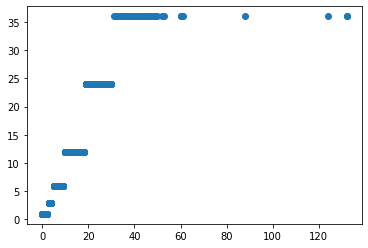

In [73]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [74]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [75]:
df_A.head()

curr        BU   period  DC_amount  US_amount  rebill_months
0  AUD  Creative  2015-01      12.49      10.68            1.0
1  AUD  Creative  2015-01      44.96      38.44            1.0
2  AUD  Creative  2015-01      14.98      12.80            1.0
3  AUD  Creative  2015-01     668.96     571.90            1.0
4  AUD  Creative  2015-01      49.96      42.72            1.0

In [76]:
df_A.rename(index = str, columns={'currency': 'curr', 'Enterprise BU Desc':'BU', 
             'Invoice Fiscal Year Period Desc': 'period'}, inplace=True)


In [77]:
df_A.head(10)

curr        BU   period  DC_amount  US_amount  rebill_months
0  AUD  Creative  2015-01      12.49      10.68            1.0
1  AUD  Creative  2015-01      44.96      38.44            1.0
2  AUD  Creative  2015-01      14.98      12.80            1.0
3  AUD  Creative  2015-01     668.96     571.90            1.0
4  AUD  Creative  2015-01      49.96      42.72            1.0
5  AUD  Creative  2015-01      74.94      64.08            1.0
6  AUD  Creative  2015-01     132.39     111.30            1.0
7  AUD  Creative  2015-01     194.84     163.80            1.0
8  AUD  Creative  2015-01      57.45      48.12            1.0
9  AUD  Creative  2015-01     688.94     571.55            1.0

In [78]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp_DC = df_A.pivot_table('DC_amount', ['curr', 'BU', 'period'], 'rebill_months')
temp_US = df_A.pivot_table('US_amount', ['curr', 'BU', 'period'], 'rebill_months')


In [79]:
temp_DC

rebill_months                           1.0         3.0   6.0           12.0  \
curr BU                 period                                                 
AUD  Creative           2015-01   172.835000         NaN   NaN           NaN   
                        2015-02  6449.135714  242.726667   NaN   4948.392414   
                        2015-03  6231.454186  300.000000   NaN   4515.238684   
                        2015-04  6621.168000  128.180000   NaN   6022.798621   
                        2015-05  6089.745000  300.000000   NaN   5200.928065   
...                                      ...         ...   ...           ...   
USD  Print & Publishing 2019-11  2204.583333         NaN   NaN  56466.250000   
                        2019-12  2321.481481         NaN   NaN  57593.529412   
                        2020-01  1798.400000         NaN   NaN   1193.333333   
                        2020-02  1876.521739         NaN   NaN  13127.272727   
                        2020-03  2080.000000         NaN   NaN   1443.125000   

rebill_months                          24.0  36.0  
curr BU                 period                     
AUD  Creative           2015-01         NaN   NaN  
                        2015-02  895.991176   NaN  
                        2015-03  739.925000   NaN  
                        2015-04  614.616667   NaN  
                        2015-05  636.906667   NaN  
...                                     ...   ...  
USD  Print & Publishing 2019-11         NaN   NaN  
                        2019-12         NaN   NaN  
                        2020-01         NaN   NaN  
                        2020-02         NaN   NaN  
                        2020-03         NaN   NaN  

[1369 rows x 6 columns]

In [80]:
temp_DC = temp_DC.fillna(0)
temp_US = temp_DC.fillna(0)

In [81]:
temp_US

rebill_months                           1.0         3.0   6.0           12.0  \
curr BU                 period                                                 
AUD  Creative           2015-01   172.835000    0.000000   0.0      0.000000   
                        2015-02  6449.135714  242.726667   0.0   4948.392414   
                        2015-03  6231.454186  300.000000   0.0   4515.238684   
                        2015-04  6621.168000  128.180000   0.0   6022.798621   
                        2015-05  6089.745000  300.000000   0.0   5200.928065   
...                                      ...         ...   ...           ...   
USD  Print & Publishing 2019-11  2204.583333    0.000000   0.0  56466.250000   
                        2019-12  2321.481481    0.000000   0.0  57593.529412   
                        2020-01  1798.400000    0.000000   0.0   1193.333333   
                        2020-02  1876.521739    0.000000   0.0  13127.272727   
                        2020-03  2080.000000    0.000000   0.0   1443.125000   

rebill_months                          24.0  36.0  
curr BU                 period                     
AUD  Creative           2015-01    0.000000   0.0  
                        2015-02  895.991176   0.0  
                        2015-03  739.925000   0.0  
                        2015-04  614.616667   0.0  
                        2015-05  636.906667   0.0  
...                                     ...   ...  
USD  Print & Publishing 2019-11    0.000000   0.0  
                        2019-12    0.000000   0.0  
                        2020-01    0.000000   0.0  
                        2020-02    0.000000   0.0  
                        2020-03    0.000000   0.0  

[1369 rows x 6 columns]

In [82]:
temp_flat_DC = pd.DataFrame(temp_DC.to_records())
temp_flat_US = pd.DataFrame(temp_US.to_records())

In [83]:
temp_flat_DC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curr    1369 non-null   object 
 1   BU      1369 non-null   object 
 2   period  1369 non-null   object 
 3   1.0     1369 non-null   float64
 4   3.0     1369 non-null   float64
 5   6.0     1369 non-null   float64
 6   12.0    1369 non-null   float64
 7   24.0    1369 non-null   float64
 8   36.0    1369 non-null   float64
dtypes: float64(6), object(3)
memory usage: 96.4+ KB


In [84]:
temp_flat_DC.rename(index=str, columns={'1.0':'deferred_1M_DC', 
                               '3.0':'deferred_3M_DC',
                               '6.0':'deferred_6M_DC',
                               '12.0':'deferred_1Y_DC',
                               '24.0':'deferred_2Y_DC',
                               '36.0': 'deferred_3Y_DC'}, inplace=True)

temp_flat_US.rename(index=str, columns={'1.0':'deferred_1M_US', 
                               '3.0':'deferred_3M_US',
                               '6.0':'deferred_6M_US',
                               '12.0':'deferred_1Y_US',
                               '24.0':'deferred_2Y_US',
                               '36.0': 'deferred_3Y_US'}, inplace=True)


In [85]:
temp_flat_DC.tail(20)

curr                  BU   period  deferred_1M_DC  deferred_3M_DC  \
1349  USD  Print & Publishing  2018-08    18863.692258    1.609095e+04   
1350  USD  Print & Publishing  2018-09    74664.437209    1.460916e+06   
1351  USD  Print & Publishing  2018-10     8797.135172    8.076400e+02   
1352  USD  Print & Publishing  2018-11    35892.827586    2.153162e+06   
1353  USD  Print & Publishing  2018-12    25516.156765    0.000000e+00   
1354  USD  Print & Publishing  2019-01     2867.777778    0.000000e+00   
1355  USD  Print & Publishing  2019-02    14035.777619    0.000000e+00   
1356  USD  Print & Publishing  2019-03     2515.806452    0.000000e+00   
1357  USD  Print & Publishing  2019-04     2606.173913    7.500000e+03   
1358  USD  Print & Publishing  2019-05     2048.000000    7.500000e+03   
1359  USD  Print & Publishing  2019-06     2331.333333    0.000000e+00   
1360  USD  Print & Publishing  2019-07     2492.727273    0.000000e+00   
1361  USD  Print & Publishing  2019-08     2007.461538    0.000000e+00   
1362  USD  Print & Publishing  2019-09     2366.551724    0.000000e+00   
1363  USD  Print & Publishing  2019-10     2391.818182    0.000000e+00   
1364  USD  Print & Publishing  2019-11     2204.583333    0.000000e+00   
1365  USD  Print & Publishing  2019-12     2321.481481    0.000000e+00   
1366  USD  Print & Publishing  2020-01     1798.400000    0.000000e+00   
1367  USD  Print & Publishing  2020-02     1876.521739    0.000000e+00   
1368  USD  Print & Publishing  2020-03     2080.000000    0.000000e+00   

      deferred_6M_DC  deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  
1349            0.00    33614.666667             0.0             0.0  
1350       258217.04    24708.153846             0.0             0.0  
1351            0.00    81043.157895             0.0             0.0  
1352            0.00    73684.812105             0.0             0.0  
1353       249999.99    81120.952381             0.0             0.0  
1354            0.00     3615.000000             0.0             0.0  
1355            0.00    34180.769231             0.0             0.0  
1356            0.00     2179.285714             0.0             0.0  
1357            0.00     1764.615385             0.0             0.0  
1358            0.00     2070.000000             0.0             0.0  
1359            0.00    20321.176471             0.0             0.0  
1360            0.00    47825.555556             0.0             0.0  
1361            0.00     1964.615385             0.0             0.0  
1362            0.00    33156.500000             0.0             0.0  
1363            0.00    91562.857143             0.0             0.0  
1364            0.00    56466.250000             0.0             0.0  
1365            0.00    57593.529412             0.0             0.0  
1366            0.00     1193.333333             0.0             0.0  
1367            0.00    13127.272727             0.0             0.0  
1368            0.00     1443.125000             0.0             0.0

In [86]:
df.head(30)

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0   ARS  Creative  2019-07        6786.00         155.12         0.0   
1   ARS  Creative  2019-08       16472.00         390.02         0.0   
2   ARS  Creative  2019-09       19205.00         405.51         0.0   
3   ARS  Creative  2019-10       30382.19         532.13         0.0   
4   ARS  Creative  2019-11       59049.00        1023.67         0.0   
5   ARS  Creative  2019-12       71355.57        1195.94         0.0   
6   ARS  Creative  2020-01       79224.95        1323.41         0.0   
7   ARS  Creative  2020-02       36596.00         611.42         0.0   
8   ARS  Creative  2020-03       49107.00         810.06         0.0   
9   ARS  Creative  2020-04       20858.00         336.07         0.0   
10  AUD  Creative  2015-01      191897.46      160229.26         0.0   
11  AUD  Creative  2015-02      142877.43      115351.47         0.0   
12  AUD  Creative  2015-03      469421.63      366607.53         0.0   
13  AUD  Creative  2015-04      272007.87      210919.45         0.0   
14  AUD  Creative  2015-05      347422.78      266694.39         0.0   
15  AUD  Creative  2015-06      490156.86      386756.56         0.0   
16  AUD  Creative  2015-07      235045.62      181474.06         0.0   
17  AUD  Creative  2015-08      284334.70      215057.39         0.0   
18  AUD  Creative  2015-09      369648.88      271767.81         0.0   
19  AUD  Creative  2015-10      287292.48      203131.14         0.0   
20  AUD  Creative  2015-11      361723.22      257204.76         0.0   
21  AUD  Creative  2015-12      276178.28      197189.56         0.0   
22  AUD  Creative  2016-01      270306.21      195754.34         0.0   
23  AUD  Creative  2016-02      116996.45       85347.42         0.0   
24  AUD  Creative  2016-03      235382.84      167438.88         0.0   
25  AUD  Creative  2016-04      249819.19      186769.73         0.0   
26  AUD  Creative  2016-05      213088.53      162597.81         0.0   
27  AUD  Creative  2016-06      246758.37      184155.15         0.0   
28  AUD  Creative  2016-07      202289.36      149503.00         0.0   
29  AUD  Creative  2016-08      151958.31      114297.70         0.0   

    service_US  deferred_B_DC  deferred_B_US  deferred_3M_DC  ...  \
0          0.0            0.0            0.0             0.0  ...   
1          0.0            0.0            0.0             0.0  ...   
2          0.0            0.0            0.0             0.0  ...   
3          0.0            0.0            0.0             0.0  ...   
4          0.0            0.0            0.0             0.0  ...   
5          0.0            0.0            0.0             0.0  ...   
6          0.0            0.0            0.0             0.0  ...   
7          0.0            0.0            0.0             0.0  ...   
8          0.0            0.0            0.0             0.0  ...   
9          0.0            0.0            0.0             0.0  ...   
10         0.0            0.0            0.0             0.0  ...   
11         0.0            0.0            0.0             0.0  ...   
12         0.0            0.0            0.0             0.0  ...   
13         0.0            0.0            0.0             0.0  ...   
14         0.0            0.0            0.0             0.0  ...   
15         0.0            0.0            0.0             0.0  ...   
16         0.0            0.0            0.0             0.0  ...   
17         0.0            0.0            0.0             0.0  ...   
18         0.0            0.0            0.0             0.0  ...   
19         0.0            0.0            0.0             0.0  ...   
20         0.0            0.0            0.0             0.0  ...   
21         0.0            0.0            0.0             0.0  ...   
22         0.0            0.0            0.0             0.0  ...   
23         0.0            0.0            0.0             0.0  ...   
24         0.0            0.0            0.0 

In [87]:
df_test_dup = df.copy()
print(len(df_test_dup))

4154


In [88]:
df_test_dup =df_test_dup.drop_duplicates(subset=['curr', 'BU', 'period'])

In [89]:
print(len(df_test_dup))

4154


## Now we have to merge these two dataframes with the other billings dataframe

In [90]:
''' def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged
'''

" def merge_new_dataframe(old_df, new_df, new_column):\n    df_merged = pd.merge(old_df, new_df, how='outer', \n                     left_on=['curr', 'BU', 'period'],\n                    right_on=['curr', 'BU', 'period'])\n    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)\n    \n    #need to drop the product configtype id for merges where the new_df is of type A\n    config_str = 'config'\n    rule_str = 'rebill_rule'\n    if config_str in df_merged.columns:\n        df_merged.drop(columns=['config'], inplace=True)\n    \n    if rule_str in df_merged.columns:\n        df_merged.drop(columns=['rebill_rule'], inplace=True)\n        \n    return df_merged\n"

In [91]:
temp_flat_DC.head(30)

curr        BU   period  deferred_1M_DC  deferred_3M_DC  deferred_6M_DC  \
0   AUD  Creative  2015-01      172.835000        0.000000            0.00   
1   AUD  Creative  2015-02     6449.135714      242.726667            0.00   
2   AUD  Creative  2015-03     6231.454186      300.000000            0.00   
3   AUD  Creative  2015-04     6621.168000      128.180000            0.00   
4   AUD  Creative  2015-05     6089.745000      300.000000            0.00   
5   AUD  Creative  2015-06     7410.857222      412.730000            0.00   
6   AUD  Creative  2015-08     7284.192982      257.045000            0.00   
7   AUD  Creative  2015-09     7122.768056        0.000000            0.00   
8   AUD  Creative  2015-10     6726.175517      128.180000            0.00   
9   AUD  Creative  2015-11     6896.387241      450.000000            0.00   
10  AUD  Creative  2015-12     6904.457222      300.000000            0.00   
11  AUD  Creative  2016-01      -11.984000        0.000000            0.00   
12  AUD  Creative  2016-02     6664.847500      289.090000          412.73   
13  AUD  Creative  2016-03     6219.013333        0.000000            0.00   
14  AUD  Creative  2016-05     6710.357931      128.180000            0.00   
15  AUD  Creative  2016-06     6174.654531        0.000000          412.73   
16  AUD  Creative  2016-07     6045.849310      128.180000            0.00   
17  AUD  Creative  2016-08     6202.775862        0.000000            0.00   
18  AUD  Creative  2016-09     5923.717778        0.000000            0.00   
19  AUD  Creative  2016-10     5948.620000      128.180000            0.00   
20  AUD  Creative  2016-11     5906.068276        0.000000            0.00   
21  AUD  Creative  2016-12    11460.629459        0.000000          825.46   
22  AUD  Creative  2017-02    -5889.663611        0.000000         -412.73   
23  AUD  Creative  2017-03     5834.551828      214.090000            0.00   
24  AUD  Creative  2017-04     6343.430000      128.180000            0.00   
25  AUD  Creative  2017-05     5615.712414        0.000000            0.00   
26  AUD  Creative  2017-06     5477.573684        0.000000          412.73   
27  AUD  Creative  2017-07      -12.990000        0.000000            0.00   
28  AUD  Creative  2017-08     5664.959828      128.180000            0.00   
29  AUD  Creative  2017-09     5736.605278        0.000000            0.00   

    deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  
0         0.000000        0.000000             0.0  
1      4948.392414      895.991176             0.0  
2      4515.238684      739.925000             0.0  
3      6022.798621      614.616667             0.0  
4      5200.928065      636.906667             0.0  
5      4954.487778      608.377500             0.0  
6      5985.608103      648.305882             0.0  
7      5801.415278      741.312857             0.0  
8      5229.060000      597.380000             0.0  
9      5751.434138      672.630769             0.0  
10     5494.975143      873.755625             0.0  
11      -96.972759        0.000000             0.0  
12     4999.167778      615.473684             0.0  
13     4718.651714      828.813636             0.0  
14     5914.950357      721.581818             0.0  
15     5168.656719      628.740000             0.0  
16     5511.125172      854.942500             0.0  
17     5728.012857      501.233333             0.0  
18     5249.448571      772.580000             0.0  
19     5689.101429        0.000000             0.0  
20     4899.033448        0.000000             0.0  
21    -1123.722973        0.000000             0.0  
22     5741.638378        0.000000             0.0  
23     4441.292174      401.670000             0.0  
24     5228.344138        0.000000             0.0  
25     4564.399655     1143.490000             0.0  
26     4842.669444        0.000000             0.0  
27        0.000000        0.000000             0.0  
28     5456.902679        0.000000             

In [92]:
df_with_A = pd.merge(df, temp_flat_DC, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'], indicator=True, validate='one_to_one')
#df_with_A = df_with_A.fillna(value=0)

In [93]:
#df_with_A = df_with_A.fillna({col: scalar for col in df.columns})
df_with_A = df_with_A.fillna(pd.Series(0, index=df_with_A.select_dtypes(exclude='category').columns))

In [94]:
df_with_A.head(30)

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0   ARS  Creative  2019-07        6786.00         155.12         0.0   
1   ARS  Creative  2019-08       16472.00         390.02         0.0   
2   ARS  Creative  2019-09       19205.00         405.51         0.0   
3   ARS  Creative  2019-10       30382.19         532.13         0.0   
4   ARS  Creative  2019-11       59049.00        1023.67         0.0   
5   ARS  Creative  2019-12       71355.57        1195.94         0.0   
6   ARS  Creative  2020-01       79224.95        1323.41         0.0   
7   ARS  Creative  2020-02       36596.00         611.42         0.0   
8   ARS  Creative  2020-03       49107.00         810.06         0.0   
9   ARS  Creative  2020-04       20858.00         336.07         0.0   
10  AUD  Creative  2015-01      191897.46      160229.26         0.0   
11  AUD  Creative  2015-02      142877.43      115351.47         0.0   
12  AUD  Creative  2015-03      469421.63      366607.53         0.0   
13  AUD  Creative  2015-04      272007.87      210919.45         0.0   
14  AUD  Creative  2015-05      347422.78      266694.39         0.0   
15  AUD  Creative  2015-06      490156.86      386756.56         0.0   
16  AUD  Creative  2015-07      235045.62      181474.06         0.0   
17  AUD  Creative  2015-08      284334.70      215057.39         0.0   
18  AUD  Creative  2015-09      369648.88      271767.81         0.0   
19  AUD  Creative  2015-10      287292.48      203131.14         0.0   
20  AUD  Creative  2015-11      361723.22      257204.76         0.0   
21  AUD  Creative  2015-12      276178.28      197189.56         0.0   
22  AUD  Creative  2016-01      270306.21      195754.34         0.0   
23  AUD  Creative  2016-02      116996.45       85347.42         0.0   
24  AUD  Creative  2016-03      235382.84      167438.88         0.0   
25  AUD  Creative  2016-04      249819.19      186769.73         0.0   
26  AUD  Creative  2016-05      213088.53      162597.81         0.0   
27  AUD  Creative  2016-06      246758.37      184155.15         0.0   
28  AUD  Creative  2016-07      202289.36      149503.00         0.0   
29  AUD  Creative  2016-08      151958.31      114297.70         0.0   

    service_US  deferred_B_DC  deferred_B_US  deferred_3M_DC_x  ...  \
0          0.0            0.0            0.0               0.0  ...   
1          0.0            0.0            0.0               0.0  ...   
2          0.0            0.0            0.0               0.0  ...   
3          0.0            0.0            0.0               0.0  ...   
4          0.0            0.0            0.0               0.0  ...   
5          0.0            0.0            0.0               0.0  ...   
6          0.0            0.0            0.0               0.0  ...   
7          0.0            0.0            0.0               0.0  ...   
8          0.0            0.0            0.0               0.0  ...   
9          0.0            0.0            0.0               0.0  ...   
10         0.0            0.0            0.0               0.0  ...   
11         0.0            0.0            0.0               0.0  ...   
12         0.0            0.0            0.0               0.0  ...   
13         0.0            0.0            0.0               0.0  ...   
14         0.0            0.0            0.0               0.0  ...   
15         0.0            0.0            0.0               0.0  ...   
16         0.0            0.0            0.0               0.0  ...   
17         0.0            0.0            0.0               0.0  ...   
18         0.0            0.0            0.0               0.0  ...   
19         0.0            0.0            0.0               0.0  ...   
20         0.0            0.0            0.0               0.0  ...   
21         0.0            0.0            0.0               0.0  ...   
22         0.0            0.0            0.0               0.0  ...   
23         0.0            0.0            0.0               0.0  ..

In [95]:
df_with_all = pd.merge(df_with_A, temp_flat_US, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
#df_with_all = df_with_all.fillna(0)

In [96]:
df_with_all = df_with_all.fillna(pd.Series(0, index=df_with_all.select_dtypes(exclude='category').columns))

In [97]:
df_with_all.head(10)

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0  ARS  Creative  2019-07        6786.00         155.12         0.0   
1  ARS  Creative  2019-08       16472.00         390.02         0.0   
2  ARS  Creative  2019-09       19205.00         405.51         0.0   
3  ARS  Creative  2019-10       30382.19         532.13         0.0   
4  ARS  Creative  2019-11       59049.00        1023.67         0.0   
5  ARS  Creative  2019-12       71355.57        1195.94         0.0   
6  ARS  Creative  2020-01       79224.95        1323.41         0.0   
7  ARS  Creative  2020-02       36596.00         611.42         0.0   
8  ARS  Creative  2020-03       49107.00         810.06         0.0   
9  ARS  Creative  2020-04       20858.00         336.07         0.0   

   service_US  deferred_B_DC  deferred_B_US  deferred_3M_DC_x  ...  \
0         0.0            0.0            0.0               0.0  ...   
1         0.0            0.0            0.0               0.0  ...   
2         0.0            0.0            0.0               0.0  ...   
3         0.0            0.0            0.0               0.0  ...   
4         0.0            0.0            0.0               0.0  ...   
5         0.0            0.0            0.0               0.0  ...   
6         0.0            0.0            0.0               0.0  ...   
7         0.0            0.0            0.0               0.0  ...   
8         0.0            0.0            0.0               0.0  ...   
9         0.0            0.0            0.0               0.0  ...   

   deferred_1Y_DC_y  deferred_2Y_DC_y  deferred_3Y_DC_y     _merge  \
0               0.0               0.0               0.0  left_only   
1               0.0               0.0               0.0  left_only   
2               0.0               0.0               0.0  left_only   
3               0.0               0.0               0.0  left_only   
4               0.0               0.0               0.0  left_only   
5               0.0               0.0               0.0  left_only   
6               0.0               0.0               0.0  left_only   
7               0.0               0.0               0.0  left_only   
8               0.0               0.0               0.0  left_only   
9               0.0               0.0               0.0  left_only   

   deferred_1M_US_y  deferred_3M_US_y  deferred_6M_US_y  deferred_1Y_US_y  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   
5               0.0               0.0               0.0               0.0   
6               0.0               0.0               0.0               0.0   
7               0.0               0.0               0.0               0.0   
8               0.0               0.0               0.0               0.0   
9               0.0               0.0               0.0               0.0   

   deferred_2Y_US_y  deferred_3Y_US_y  
0               0.0               0.0  
1               0.0               0.0  
2               0.0               0.0  
3               0.0               0.0  
4               0.0               0.0  
5               0.0               0.0  
6               0.0               0.0  
7               0.0               0.0  
8               0.0               0.0  
9               0.0               0.0  

[10 rows x 34 columns]

In [98]:
df_with_all['deferred_1M_DC']= df_with_all['deferred_1M_DC_x']+df_with_all['deferred_1M_DC_y']
df_with_all['deferred_3M_DC']= df_with_all['deferred_3M_DC_x']+df_with_all['deferred_3M_DC_y']
df_with_all['deferred_6M_DC']= df_with_all['deferred_6M_DC_x']+df_with_all['deferred_6M_DC_y']
df_with_all['deferred_1Y_DC']= df_with_all['deferred_1Y_DC_x']+df_with_all['deferred_1Y_DC_y']
df_with_all['deferred_2Y_DC']= df_with_all['deferred_2Y_DC_x']+df_with_all['deferred_2Y_DC_y']
df_with_all['deferred_3Y_DC']= df_with_all['deferred_3Y_DC_x']+df_with_all['deferred_3Y_DC_y']

df_with_all['deferred_1M_US']= df_with_all['deferred_1M_US_x']+df_with_all['deferred_1M_US_y']
df_with_all['deferred_3M_US']= df_with_all['deferred_3M_US_x']+df_with_all['deferred_3M_US_y']
df_with_all['deferred_6M_US']= df_with_all['deferred_6M_US_x']+df_with_all['deferred_6M_US_y']
df_with_all['deferred_1Y_US']= df_with_all['deferred_1Y_US_x']+df_with_all['deferred_1Y_US_y']
df_with_all['deferred_2Y_US']= df_with_all['deferred_2Y_US_x']+df_with_all['deferred_2Y_US_y']
df_with_all['deferred_3Y_US']= df_with_all['deferred_3Y_US_x']+df_with_all['deferred_3Y_US_y']

In [99]:
df_with_all.drop(labels = ['deferred_1M_DC_x','deferred_1M_DC_y',
                        'deferred_3M_DC_x','deferred_3M_DC_y',
                        'deferred_6M_DC_x','deferred_6M_DC_y',
                        'deferred_1Y_DC_x','deferred_1Y_DC_y',
                        'deferred_2Y_DC_x','deferred_2Y_DC_y',
                        'deferred_3Y_DC_x','deferred_3Y_DC_y',
                        'deferred_1M_US_x','deferred_1M_US_y',   
                        'deferred_3M_US_x','deferred_3M_US_y',
                        'deferred_6M_US_x','deferred_6M_US_y',
                        'deferred_1Y_US_x','deferred_1Y_US_y',
                        'deferred_2Y_US_x','deferred_2Y_US_y',
                        'deferred_3Y_US_x','deferred_3Y_US_y'],
                 axis=1, inplace=True)

In [100]:
df_with_all.head()

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0  ARS  Creative  2019-07        6786.00         155.12         0.0   
1  ARS  Creative  2019-08       16472.00         390.02         0.0   
2  ARS  Creative  2019-09       19205.00         405.51         0.0   
3  ARS  Creative  2019-10       30382.19         532.13         0.0   
4  ARS  Creative  2019-11       59049.00        1023.67         0.0   

   service_US  deferred_B_DC  deferred_B_US     _merge  ...  deferred_6M_DC  \
0         0.0            0.0            0.0  left_only  ...             0.0   
1         0.0            0.0            0.0  left_only  ...             0.0   
2         0.0            0.0            0.0  left_only  ...             0.0   
3         0.0            0.0            0.0  left_only  ...             0.0   
4         0.0            0.0            0.0  left_only  ...             0.0   

   deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  deferred_1M_US  \
0       953875.89             0.0             0.0       146091.12   
1       963180.00             0.0             0.0       173274.71   
2      2263704.00             0.0             0.0       217611.17   
3      1318346.81             0.0             0.0       181706.80   
4      1494162.20             0.0             0.0       196031.97   

   deferred_3M_US  deferred_6M_US  deferred_1Y_US  deferred_2Y_US  \
0             0.0             0.0        21566.14             0.0   
1             0.0             0.0        22781.91             0.0   
2             0.0             0.0        46297.25             0.0   
3             0.0             0.0        23376.52             0.0   
4             0.0             0.0        25782.35             0.0   

   deferred_3Y_US  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 22 columns]

In [101]:
df_with_all.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', '_merge',
       'deferred_1M_DC', 'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC',
       'deferred_2Y_DC', 'deferred_3Y_DC', 'deferred_1M_US', 'deferred_3M_US',
       'deferred_6M_US', 'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')

In [102]:
df_with_all['deferred_1Y_US'].describe()

count    4.183000e+03
mean     5.334600e+06
std      1.952199e+07
min     -4.112170e+07
25%      1.788765e+03
50%      1.138982e+05
75%      1.280027e+06
max      2.738133e+08
Name: deferred_1Y_US, dtype: float64

In [103]:
df['deferred_1Y_US'].describe()

count    4.154000e+03
mean     5.307626e+06
std      1.954335e+07
min     -4.112170e+07
25%      1.967878e+03
50%      1.129077e+05
75%      1.258513e+06
max      2.738133e+08
Name: deferred_1Y_US, dtype: float64

In [104]:
print('sum of temp flat DC 1M', temp_flat_DC['deferred_1M_DC'].sum())
print('sum of base_df before DC 1M', df['deferred_1M_DC'].sum())
print('sum of final DC 1M', df_with_all['deferred_1M_DC'].sum())

a = temp_flat_DC['deferred_1M_DC'].sum()
b = df['deferred_1M_DC'].sum()
c = df_with_all['deferred_1M_DC'].sum()
print(c)
print(a+b)

sum of temp flat DC 1M 355116274.5532136
sum of base_df before DC 1M 161228719447.5
sum of final DC 1M 161583835722.05322
161583835722.05322
161583835722.05322


In [105]:
df['deferred_1M_DC'].sum()

161228719447.5

In [106]:
temp_flat_DC['deferred_1M_DC'].sum()

355116274.5532136

In [107]:
df_with_all['deferred_1M_DC'].sum()

161583835722.05322

# Need to create a table that contains the total billings by DC for each dataframe and each step for auditing

 - start with all of the DC
 - then create function that appends and adds rows
 - then do the same for the DC stuff type_A
 - then check the totals


In [108]:
df = df_with_all.copy()

In [109]:
drop_index= df[df['period']=='2020-04'].index
df.drop(drop_index, inplace=True)

In [ ]:
# dump the pickle
#pickle.dump(df, open('../data/processed/all_billings.p', 'wb'))

# open the pickle file
df = pickle.load(open('../data/processed/all_billings.p', 'rb'))

In [ ]:
df['period'].unique()

In [ ]:
len(df)

## Loading All of the other information we need here
 - filename = currency_map

In [110]:
df_curr_map= pd.read_excel('../data/currency_map.xlsx', sheet_name='curr_map')
df_curr_map['Country'] = df_curr_map['Country'].str.replace('\(MA\)', '', case=False)

In [111]:
df_FX_rates = pd.read_excel('../data/FX_data.xlsx', sheet_name='to_matlab')
df_FX_rates['VOL_3M'] = df_FX_rates['VOL_3M']/100
df_FX_rates['VOL_6M'] = df_FX_rates['VOL_6M']/100
df_FX_rates['VOL_9M'] = df_FX_rates['VOL_9M']/100
df_FX_rates['VOL_1Y'] = df_FX_rates['VOL_1Y']/100

In [112]:
df_FX_fwds = pd.read_excel('../data/FX_forward_rates.xlsx', sheet_name='forward_data', 
                          skiprows = 1, usecols="C,G")

In [113]:
df_FX_fwds.rename(index=str, columns={'Unnamed: 2': 'curr', 'FWD REF':'forward'}, inplace=True)

## Working on the func_load_bookings now

In [114]:
df_bookings = pd.read_excel('../data/2020_bookings_fcst_Q1.xlsx', sheet_name='bookings')


## Cleaning up the bookings data
 - remove odd strings such as '(EB)' from BU
 - (IS) from internal segment
 - etc
 
 
 NOTE: The '(' is a special character so we need to precede these with the escape character '\'

In [115]:
df_bookings['EBU'] = df_bookings['EBU'].str.replace(' \(EB\)', '', case=False)
df_bookings['Internal Segment'] = df_bookings['Internal Segment'].str.replace('\(IS\)', '')

df_bookings['PMBU'] = df_bookings['PMBU'].str.replace('\(PMBU\)', '')
df_bookings['GEO'] = df_bookings['GEO'].str.replace('\(G\)', '')
df_bookings['Market Area'] = df_bookings['Market Area'].str.replace('\(MA\)', '')


In [116]:
df_bookings.sample(5)

Hedge               EBU   Internal Segment  \
875   Bookings - Ent Territory  Experience Cloud      Adobe Target    
3072  Bookings - Ent Territory  Experience Cloud           Magento    
297       Bookings - Ent Named  Experience Cloud  Audience Manager    
4813  Bookings - Ent Territory  Experience Cloud   Adobe Analytics    
4072      Bookings - Ent Other  Experience Cloud      Adobe Target    

                   PMBU    GEO           Market Area Mark Segment  \
875       Adobe Target   AMER                Brazil    COMMERCIAL   
3072           Magento   EMEA                 Italy    COMMERCIAL   
297   Audience Manager   ASIA   Aus and New Zealand    COMMERCIAL   
4813   Adobe Analytics   EMEA           Switzerland    COMMERCIAL   
4072      Adobe Target   EMEA                Nordic    COMMERCIAL   

                                            Type  \
875   ASV & Usage Based & Subscription Attrition   
3072  ASV & Usage Based & Subscription Attrition   
297   ASV & Usage Based & Subscription Attrition   
4813  ASV & Usage Based & Subscription Attrition   
4072             Net ACV excluding M&S Attrition   

                     Bookings Type  Quarter   Scenario            FX  \
875                            ASV  Q4 2020  QRF - Low  USD Adjusted   
3072  Total Subscription Attrition  Q1 2020  QRF - Low  USD Adjusted   
297   Total Subscription Attrition  Q4 2020  QRF - Low  USD Adjusted   
4813                           ASV  Q4 2020  QRF - Low  USD Adjusted   
4072                    Consulting  Q3 2020  QRF - Low  USD Adjusted   

             value  
875   3.971218e+05  
3072 -4.273870e+04  
297  -5.053110e+04  
4813  1.174278e+05  
4072 -1.380000e-07

In [117]:
df_bookings.EBU.value_counts()

Experience Cloud    5870
Creative              80
Document Cloud        64
Name: EBU, dtype: int64

In [118]:
df_bookings.PMBU.value_counts()

Sites                     752
Adobe Analytics           715
Adobe Campaign            691
Adobe Target              654
Assets                    624
Audience Manager          577
Forms                     567
Marketo                   464
Magento                   372
AEM Other                 272
Adobe Video Solutions     154
Acrobat Desk               32
Adobe Sign                 32
Stock Photography          32
Design                     32
Adobe Exp Platform         24
CCE + Stock                16
TubeMogul                   4
Name: PMBU, dtype: int64

In [119]:
df_bookings.GEO.value_counts()

EMEA     2582
ASIA     1932
AMER     1164
JPN       336
Name: GEO, dtype: int64

In [120]:
df_bookings['Mark Segment'].value_counts()

COMMERCIAL    5169
GOVERNMENT     484
EDUCATION      288
NON-PROFIT      73
Name: Mark Segment, dtype: int64

In [121]:
df_bookings['Type'].value_counts()

ASV & Usage Based & Subscription Attrition    4765
Net ACV excluding M&S Attrition               1249
Name: Type, dtype: int64

In [122]:
df_bookings['Bookings Type'].value_counts()

Total Subscription Attrition    2904
ASV                             1861
Consulting                      1249
Name: Bookings Type, dtype: int64

In [123]:
df_bookings['Scenario'].value_counts()

QRF - Low    6014
Name: Scenario, dtype: int64

In [124]:
df_bookings['FX'].value_counts()

USD Adjusted    6014
Name: FX, dtype: int64

In [125]:
df_bookings.sample(5)

Hedge               EBU           Internal Segment  \
2038  Bookings - Ent Territory  Experience Cloud  Adobe Experience Manager    
1701  Bookings - Ent Territory  Experience Cloud                   Magento    
3440      Bookings - Ent Other  Experience Cloud  Adobe Experience Manager    
4379      Bookings - Ent Other  Experience Cloud          Audience Manager    
1773  Bookings - Ent Territory  Experience Cloud  Adobe Experience Manager    

                   PMBU    GEO      Market Area Mark Segment  \
2038            Assets   EMEA          Germany    COMMERCIAL   
1701           Magento   EMEA           France    COMMERCIAL   
3440            Assets    JPN            Japan    COMMERCIAL   
4379  Audience Manager   ASIA   Southeast Asia    COMMERCIAL   
1773             Forms   EMEA           France    COMMERCIAL   

                                            Type  \
2038             Net ACV excluding M&S Attrition   
1701  ASV & Usage Based & Subscription Attrition   
3440  ASV & Usage Based & Subscription Attrition   
4379  ASV & Usage Based & Subscription Attrition   
1773  ASV & Usage Based & Subscription Attrition   

                     Bookings Type  Quarter   Scenario            FX  \
2038                    Consulting  Q4 2020  QRF - Low  USD Adjusted   
1701                           ASV  Q4 2020  QRF - Low  USD Adjusted   
3440                           ASV  Q4 2020  QRF - Low  USD Adjusted   
4379  Total Subscription Attrition  Q3 2020  QRF - Low  USD Adjusted   
1773  Total Subscription Attrition  Q2 2020  QRF - Low  USD Adjusted   

              value  
2038     447.768540  
1701  415461.280539  
3440  177790.156613  
4379  -63846.957894  
1773   -3823.783497

In [126]:
df_bookings.drop(columns = ['Hedge', 'Mark Segment', 'Type', 'Scenario', 'FX'], inplace = True)

In [127]:
df_bookings.rename(index=str, columns = {'EBU': 'BU', 
                                        'Internal Segment': 'segment',
                                        'PMBU': 'product',
                                        'GEO':'geo',
                                        'Market Area': 'country',
                                        'Bookings Type': 'booking_type',
                                        'value': 'US_amount'}, inplace =True)

In [128]:
df_curr_map.head(5)

Country Currency
0  Aus and New Zealand       AUD
1              Benelux       EUR
2               Brazil       USD
3               Canada       USD
4                China       USD

In [129]:
df_bookings['country'].unique()

array(['Aus and New Zealand ', 'Benelux ', 'Brazil ', 'Canada ', 'China ',
       'Eastern Europe ', 'France ', 'Germany ', 'Hong Kong & Taiwan ',
       'Iberica ', 'India ', 'Italy ', 'Japan ', 'Korea ',
       'Mediterranean ', 'Mexico ', 'Middle East ', 'Nordic ',
       'Russia & CIS ', 'Southeast Asia ', 'SSA & Israel ',
       'Strat. Latin America ', 'Switzerland ', 'United Kingdom ',
       'United States '], dtype=object)

In [130]:
list_book_ctry = df_bookings['country'].unique()


In [131]:
list_curr_map = df_curr_map['Country'].unique()

In [132]:
a = list(set(list_book_ctry) & set(list_curr_map))
a

['Mexico ',
 'France ',
 'Brazil ',
 'Germany ',
 'Strat. Latin America ',
 'SSA & Israel ',
 'Japan ',
 'Benelux ',
 'Nordic ',
 'Korea ',
 'Switzerland ',
 'Italy ',
 'United States ',
 'Middle East ',
 'Russia & CIS ',
 'Eastern Europe ',
 'Southeast Asia ',
 'Hong Kong & Taiwan ',
 'Iberica ',
 'United Kingdom ',
 'China ',
 'Aus and New Zealand ',
 'Canada ',
 'India ',
 'Mediterranean ']

In [133]:
not_in_map = set(list_book_ctry).difference(set(list_curr_map))
not_in_map

set()

In [134]:
not_in_map = set()
not_in_map

set()

In [135]:
len(not_in_map)

0

In [136]:
df_bookings = pd.merge(df_bookings, df_curr_map, how='left', left_on='country', right_on='Country')

In [137]:
df_bookings.sample(10)

BU                    segment            product    geo  \
4524  Experience Cloud  Adobe Experience Manager              Sites   ASIA    
881   Experience Cloud          Audience Manager   Audience Manager   AMER    
4281  Experience Cloud            Adobe Campaign     Adobe Campaign   ASIA    
3621  Experience Cloud              Adobe Target       Adobe Target   ASIA    
3610  Experience Cloud              Adobe Target       Adobe Target   ASIA    
927   Experience Cloud  Adobe Experience Manager              Sites   AMER    
1605  Experience Cloud           Adobe Analytics    Adobe Analytics   EMEA    
1012  Experience Cloud           Adobe Analytics    Adobe Analytics   AMER    
1913  Experience Cloud           Adobe Analytics    Adobe Analytics   EMEA    
4164  Experience Cloud  Adobe Experience Manager              Sites   EMEA    

              country                  booking_type  Quarter      US_amount  \
4524  Southeast Asia                            ASV  Q3 2020  445674.326676   
881           Brazil   Total Subscription Attrition  Q3 2020     312.279807   
4281  Southeast Asia                            ASV  Q4 2020   80543.882436   
3621           Korea                            ASV  Q3 2020    2150.399478   
3610           Korea                     Consulting  Q4 2020   41506.889917   
927           Brazil                     Consulting  Q4 2020  981896.639467   
1605          France                     Consulting  Q2 2020   76730.208661   
1012          Canada   Total Subscription Attrition  Q1 2020     -63.302803   
1913         Germany   Total Subscription Attrition  Q4 2020  -73518.700220   
4164          Nordic   Total Subscription Attrition  Q2 2020  -43628.941342   

              Country Currency  
4524  Southeast Asia       USD  
881           Brazil       USD  
4281  Southeast Asia       USD  
3621           Korea       USD  
3610           Korea       USD  
927           Brazil       USD  
1605          France       EUR  
1012          Canada       USD  
1913         Germany       EUR  
4164          Nordic       EUR

## Need to move the period_weeks from the Adobe calendar to the billings and bookings dataframes

In [138]:
df_bookings.head(10)

BU   segment   product    geo               country  \
0  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
1  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
2  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
3  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
4  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
5  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
6  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
7  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
8  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    
9  Experience Cloud  Marketo   Marketo   ASIA   Aus and New Zealand    

                   booking_type  Quarter      US_amount               Country  \
0  Total Subscription Attrition  Q1 2020 -243336.527786  Aus and New Zealand    
1  Total Subscription Attrition  Q1 2020 -309237.732096  Aus and New Zealand    
2  Total Subscription Attrition  Q1 2020  -61767.378056  Aus and New Zealand    
3  Total Subscription Attrition  Q1 2020 -503969.121094  Aus and New Zealand    
4  Total Subscription Attrition  Q2 2020 -145084.185190  Aus and New Zealand    
5  Total Subscription Attrition  Q2 2020 -184376.364697  Aus and New Zealand    
6  Total Subscription Attrition  Q2 2020  -36827.474272  Aus and New Zealand    
7  Total Subscription Attrition  Q2 2020 -325745.459992  Aus and New Zealand    
8  Total Subscription Attrition  Q3 2020 -103805.125604  Aus and New Zealand    
9  Total Subscription Attrition  Q3 2020 -131917.973491  Aus and New Zealand    

  Currency  
0      AUD  
1      AUD  
2      AUD  
3      AUD  
4      AUD  
5      AUD  
6      AUD  
7      AUD  
8      AUD  
9      AUD

# need to add the period_weeks data to both the df_bookings and df_billings dataframes

In [139]:
df.head(10)

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0   ARS  Creative  2019-07        6786.00         155.12         0.0   
1   ARS  Creative  2019-08       16472.00         390.02         0.0   
2   ARS  Creative  2019-09       19205.00         405.51         0.0   
3   ARS  Creative  2019-10       30382.19         532.13         0.0   
4   ARS  Creative  2019-11       59049.00        1023.67         0.0   
5   ARS  Creative  2019-12       71355.57        1195.94         0.0   
6   ARS  Creative  2020-01       79224.95        1323.41         0.0   
7   ARS  Creative  2020-02       36596.00         611.42         0.0   
8   ARS  Creative  2020-03       49107.00         810.06         0.0   
10  AUD  Creative  2015-01      191897.46      160229.26         0.0   

    service_US  deferred_B_DC  deferred_B_US     _merge  ...  deferred_6M_DC  \
0          0.0            0.0            0.0  left_only  ...             0.0   
1          0.0            0.0            0.0  left_only  ...             0.0   
2          0.0            0.0            0.0  left_only  ...             0.0   
3          0.0            0.0            0.0  left_only  ...             0.0   
4          0.0            0.0            0.0  left_only  ...             0.0   
5          0.0            0.0            0.0  left_only  ...             0.0   
6          0.0            0.0            0.0  left_only  ...             0.0   
7          0.0            0.0            0.0  left_only  ...             0.0   
8          0.0            0.0            0.0  left_only  ...             0.0   
10         0.0            0.0            0.0       both  ...             0.0   

    deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  deferred_1M_US  \
0        953875.89             0.0             0.0      146091.120   
1        963180.00             0.0             0.0      173274.710   
2       2263704.00             0.0             0.0      217611.170   
3       1318346.81             0.0             0.0      181706.800   
4       1494162.20             0.0             0.0      196031.970   
5       3154860.03             0.0             0.0      281781.980   
6        916705.92             0.0             0.0      239885.710   
7       1337025.94             0.0             0.0      245006.510   
8       2807012.83             0.0             0.0      355542.960   
10      1907697.60         29664.8             0.0     2664681.865   

    deferred_3M_US  deferred_6M_US  deferred_1Y_US  deferred_2Y_US  \
0              0.0             0.0        21566.14            0.00   
1              0.0             0.0        22781.91            0.00   
2              0.0             0.0        46297.25            0.00   
3              0.0             0.0        23376.52            0.00   
4              0.0             0.0        25782.35            0.00   
5              0.0             0.0        52987.34            0.00   
6              0.0             0.0        15284.18            0.00   
7              0.0             0.0        22332.22            0.00   
8              0.0             0.0        46069.05            0.00   
10             0.0             0.0      1556239.98        24592.98   

    deferred_3Y_US  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0  
10             0.0  

[10 rows x 22 columns]

In [140]:
df_cal.head(10)

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
0  2010        1       1      Q1_10 2009-11-28 2010-03-05      P1_10   
1  2010        1       2      Q1_10 2009-11-28 2010-03-05      P2_10   
2  2010        1       3      Q1_10 2009-11-28 2010-03-05      P3_10   
3  2010        2       4      Q2_10 2010-03-06 2010-06-04      P4_10   
4  2010        2       5      Q2_10 2010-03-06 2010-06-04      P5_10   
5  2010        2       6      Q2_10 2010-03-06 2010-06-04      P6_10   
6  2010        3       7      Q3_10 2010-06-05 2010-09-03      P7_10   
7  2010        3       8      Q3_10 2010-06-05 2010-09-03      P8_10   
8  2010        3       9      Q3_10 2010-06-05 2010-09-03      P9_10   
9  2010        4      10      Q4_10 2010-09-04 2010-12-03     P10_10   

   Per_Start    Per_End  Period_Weeks  
0 2009-11-28 2010-01-01             5  
1 2010-01-02 2010-01-29             4  
2 2010-01-30 2010-03-05             5  
3 2010-03-06 2010-04-02             4  
4 2010-04-03 2010-04-30             4  
5 2010-05-01 2010-06-04             5  
6 2010-06-05 2010-07-02             4  
7 2010-07-03 2010-07-30             4  
8 2010-07-31 2010-09-03             5  
9 2010-09-04 2010-10-01             4

In [141]:
# need to create a column in the df_cal with both the year then '-' and the last two digits of the per_ticker

In [142]:
df_cal['p2digit']=df_cal['Period'].astype(str)
df_cal['p2digit']=df_cal['p2digit'].str.zfill(2)
df_cal['period_match']=df_cal['Year'].astype(str) + '-' + df_cal['p2digit'].astype(str)

In [143]:
df_cal.drop(['p2digit'],axis=1, inplace=True)
df_cal.head(10)

Year  Quarter  Period Qtr_Ticker  Qtr_Start    Qtr_End Per_Ticker  \
0  2010        1       1      Q1_10 2009-11-28 2010-03-05      P1_10   
1  2010        1       2      Q1_10 2009-11-28 2010-03-05      P2_10   
2  2010        1       3      Q1_10 2009-11-28 2010-03-05      P3_10   
3  2010        2       4      Q2_10 2010-03-06 2010-06-04      P4_10   
4  2010        2       5      Q2_10 2010-03-06 2010-06-04      P5_10   
5  2010        2       6      Q2_10 2010-03-06 2010-06-04      P6_10   
6  2010        3       7      Q3_10 2010-06-05 2010-09-03      P7_10   
7  2010        3       8      Q3_10 2010-06-05 2010-09-03      P8_10   
8  2010        3       9      Q3_10 2010-06-05 2010-09-03      P9_10   
9  2010        4      10      Q4_10 2010-09-04 2010-12-03     P10_10   

   Per_Start    Per_End  Period_Weeks period_match  
0 2009-11-28 2010-01-01             5      2010-01  
1 2010-01-02 2010-01-29             4      2010-02  
2 2010-01-30 2010-03-05             5      2010-03  
3 2010-03-06 2010-04-02             4      2010-04  
4 2010-04-03 2010-04-30             4      2010-05  
5 2010-05-01 2010-06-04             5      2010-06  
6 2010-06-05 2010-07-02             4      2010-07  
7 2010-07-03 2010-07-30             4      2010-08  
8 2010-07-31 2010-09-03             5      2010-09  
9 2010-09-04 2010-10-01             4      2010-10

In [144]:
df_cal_2_merge = df_cal.copy()
df_cal_2_merge.drop(['Year', 'Quarter', 'Period', 'Qtr_Ticker', 'Qtr_Start', 'Qtr_End', 'Per_Start',
                     'Per_Ticker','Per_End'], axis=1, inplace=True)

In [145]:
df = df.merge(df_cal_2_merge, how='left', left_on='period', right_on='period_match')
df.drop(['period_match', '_merge'], axis=1, inplace=True)
df.head(20)

curr        BU   period  recognized_DC  recognized_US  service_DC  \
0   ARS  Creative  2019-07        6786.00         155.12         0.0   
1   ARS  Creative  2019-08       16472.00         390.02         0.0   
2   ARS  Creative  2019-09       19205.00         405.51         0.0   
3   ARS  Creative  2019-10       30382.19         532.13         0.0   
4   ARS  Creative  2019-11       59049.00        1023.67         0.0   
5   ARS  Creative  2019-12       71355.57        1195.94         0.0   
6   ARS  Creative  2020-01       79224.95        1323.41         0.0   
7   ARS  Creative  2020-02       36596.00         611.42         0.0   
8   ARS  Creative  2020-03       49107.00         810.06         0.0   
9   AUD  Creative  2015-01      191897.46      160229.26         0.0   
10  AUD  Creative  2015-02      142877.43      115351.47         0.0   
11  AUD  Creative  2015-03      469421.63      366607.53         0.0   
12  AUD  Creative  2015-04      272007.87      210919.45         0.0   
13  AUD  Creative  2015-05      347422.78      266694.39         0.0   
14  AUD  Creative  2015-06      490156.86      386756.56         0.0   
15  AUD  Creative  2015-07      235045.62      181474.06         0.0   
16  AUD  Creative  2015-08      284334.70      215057.39         0.0   
17  AUD  Creative  2015-09      369648.88      271767.81         0.0   
18  AUD  Creative  2015-10      287292.48      203131.14         0.0   
19  AUD  Creative  2015-11      361723.22      257204.76         0.0   

    service_US  deferred_B_DC  deferred_B_US  deferred_1M_DC  ...  \
0          0.0            0.0            0.0    6.453291e+06  ...   
1          0.0            0.0            0.0    7.305797e+06  ...   
2          0.0            0.0            0.0    1.065499e+07  ...   
3          0.0            0.0            0.0    1.030293e+07  ...   
4          0.0            0.0            0.0    1.134010e+07  ...   
5          0.0            0.0            0.0    1.680997e+07  ...   
6          0.0            0.0            0.0    1.435869e+07  ...   
7          0.0            0.0            0.0    1.466749e+07  ...   
8          0.0            0.0            0.0    2.163893e+07  ...   
9          0.0            0.0            0.0    3.192462e+06  ...   
10         0.0            0.0            0.0    3.257064e+06  ...   
11         0.0            0.0            0.0    4.453951e+06  ...   
12         0.0            0.0            0.0    3.776916e+06  ...   
13         0.0            0.0            0.0    3.712187e+06  ...   
14         0.0            0.0            0.0    5.000100e+06  ...   
15         0.0            0.0            0.0    4.115986e+06  ...   
16         0.0            0.0            0.0    4.373099e+06  ...   
17         0.0            0.0            0.0    5.672202e+06  ...   
18         0.0            0.0            0.0    4.652874e+06  ...   
19         0.0            0.0            0.0    5.084470e+06  ...   

    deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  deferred_1M_US  \
0     9.538759e+05        0.000000             0.0    1.460911e+05   
1     9.631800e+05        0.000000             0.0    1.732747e+05   
2     2.263704e+06        0.000000             0.0    2.176112e+05   
3     1.318347e+06        0.000000             0.0    1.817068e+05   
4     1.494162e+06        0.000000             0.0    1.960320e+05   
5     3.154860e+06        0.000000             0.0    2.817820e+05   
6     9.167059e+05        0.000000             0.0    2.398857e+05   
7     1.337026e+06        0.000000             0.0    2.450065e+05   
8     2.807013e+06        0.000000             0.0    3.555430e+05   
9     1.907698e+06    29664.800000             0.0    2.664682e+06   
10    1.954333e+06     1490.991176             0.0    2.649940e+06   
11    3.803546e+06    14857.925000             0.0    3.496783e+06   
12    3.103977e+06     1325.616667             0.0    2.924100e+06   
13    5.793813e+06     1176.906667             0.0    2.8576

In [146]:
df.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_1M_DC',
       'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC', 'deferred_2Y_DC',
       'deferred_3Y_DC', 'deferred_1M_US', 'deferred_3M_US', 'deferred_6M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US', 'Period_Weeks'],
      dtype='object')

In [147]:
df.sample(20)

curr                  BU   period  recognized_DC  recognized_US  \
1016  DKK  Print & Publishing  2017-09   2.980000e+03         471.91   
1194  EUR    Experience Cloud  2017-08   1.301614e+06     1485484.39   
369   CAD    Experience Cloud  2015-06  -1.742695e+05     -142686.67   
3053  USD    Experience Cloud  2016-01   1.127991e+07    11279910.34   
2885  USD            Creative  2017-10   1.016924e+07    10169241.19   
3468  CAD  Print & Publishing  2016-10   0.000000e+00           0.00   
1938  JPY    Experience Cloud  2015-07   1.832441e+07      147147.44   
3816  SEK  Print & Publishing  2019-08   0.000000e+00           0.00   
2425  NZD    Experience Cloud  2015-07   3.495583e+05      243376.48   
3913  CAD            DX Other  2018-05   0.000000e+00           0.00   
3281  USD  Print & Publishing  2019-05   7.748215e+06     7748214.79   
1699  GBP     Other Solutions  2019-11  -1.533340e+03       -1893.62   
1117  EUR      Document Cloud  2016-06   3.232243e+06     3656105.54   
4067  AUD            DX Other  2016-03   0.000000e+00           0.00   
1454  GBP            Creative  2018-11   2.350576e+05      308004.95   
2621  SEK      Document Cloud  2019-06   1.568000e+04        1633.90   
1814  JPY            Creative  2015-09   1.494134e+08     1204410.07   
849   DKK      Document Cloud  2017-08   7.560000e+03        1166.97   
3149  USD           LiveCycle  2018-10   4.628896e+04       46288.96   
917   DKK    Experience Cloud  2018-11   2.296123e+04        3548.88   

       service_DC  service_US  deferred_B_DC  deferred_B_US  deferred_1M_DC  \
1016         0.00        0.00           0.00           0.00    2.466600e+04   
1194   2114275.86  2438316.64      433339.38      498197.26    3.503427e+05   
369     480267.46   394723.41       13227.00       10948.91    0.000000e+00   
3053   6286212.61  6286212.61    10170276.75    10170276.75    1.176842e+07   
2885         0.00        0.00           0.00           0.00    1.044841e+08   
3468         0.00        0.00           0.00           0.00    0.000000e+00   
1938  28080850.00   227913.88    39816080.00      322757.95    5.918807e+07   
3816         0.00        0.00           0.00           0.00    2.633500e+04   
2425         0.00        0.00           0.00           0.00    0.000000e+00   
3913         0.00        0.00           0.00           0.00    3.000000e+03   
3281         0.00        0.00           0.00           0.00    3.548426e+05   
1699         0.00        0.00           0.00           0.00    0.000000e+00   
1117         0.00        0.00           0.00           0.00    3.200015e+05   
4067         0.00        0.00           0.00           0.00    1.487124e+04   
1454         0.00        0.00           0.00           0.00    1.312432e+07   
2621         0.00        0.00           0.00           0.00    3.852900e+05   
1814         0.00        0.00           0.00           0.00    9.390544e+08   
849          0.00        0.00           0.00           0.00    1.275835e+05   
3149         0.00        0.00           0.00           0.00    9.253000e+02   
917       5400.00      834.08           0.00           0.00    6.673689e+04   

      ...  deferred_1Y_DC  deferred_2Y_DC  deferred_3Y_DC  deferred_1M_US  \
1016  ...    0.000000e+00            0.00            0.00    3.905690e+03   
1194  ...    5.369948e+06            0.00         3885.42    3.987274e+05   
369   ...    6.242566e+05            0.00            0.00    0.000000e+00   
3053  ...    9.484014e+07         1238.00            0.00    1.176842e+07   
2885  ...    1.023090e+08        88214.46        19141.85    1.044841e+08   
3468  ...    7.423700e+03            0.00            0.00    0.000000e+00   
1938  ...    7.655023e+07            0.00            0.00    4.799695e+05   
3816  ...    0.000000e+00            0.00            0.00    2.815250e+03   
2425  ...    0.000000e+00            0.00            0.00    0.000000e+00   
3913  ...    0.000000e+00            0.00            0.00    3

In [148]:
# now I need to merge the period weeks with the df_fcst

In [149]:
df_billings=df_billings.sort_values(['curr', 'BU', 'period'], ascending = (True, True, True))

input_df_dict = {'billings':df, 
              'ADBE_cal':df_cal,
              'bookings': df_bookings,
              'FX_forwards': df_FX_fwds,
              'FX_rates': df_FX_rates
                }

pickle.dump(input_df_dict, open('../data/processed/all_inputs.p', 'wb'))

def join_new_dataframe(old_df, new_df, new_column):
    df_joined = old_df.join(new_df, how='outer')
    df_joined.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    df_joined.fillna(value=0, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_joined.columns:
        df_joined.drop(columns=['config'], inplace=True)
    
    if rule_str in df_joined.columns:
        df_joined.drop(columns=['rebill_rule'], inplace=True)
        
    return df_joined


def join_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        print('referencing the column: ', list_columns[i])
        #print(df.columns)
        # setting the index to be 'curr', 'BU' and 'period'
        df.set_index(['curr', 'BU', 'period'], drop=True, inplace=True, verify_integrity=True)
        print(df.head(4))
        #if i==0:
            #df_joined = df.copy()
            #df_joined = list_df[0].copy()
            #df_joined.rename(index=str, columns={'DC_amount': list_columns[i]+'_DC', 
            #                                     'US_amount': list_columns[i]+'_US'}, inplace=True)
        #else:
            #df_joined = join_new_dataframe(df_joined, df, list_columns[i])

    #return df_joined
    x=1
    return x 